In [ ]:
# Training models

#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from prettytable import PrettyTable  # To print in tabular format


from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, fbeta_score, classification_report# Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score


from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim 

from sklearn.cluster import KMeans

import xgboost as xgb

from scipy.optimize import linear_sum_assignment
from scipy.stats import mode

import pickle # sauver les machines dans le disque

In [2]:
file_path = "../saved_model/"

In [3]:

def false_alarm_rate(y_true, y_pred):
    """
    This function will return False Alarm Rate for given true and predicted values.
    False Alarm Rate is average of False Negetive Rate and False Positive Rate
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)  # False positive rate
    FNR = fn / (fn + tp)  # False negetive rate
    return (FPR+FNR)/2  # False alarm rate

In [4]:
def evaluate_result(clf, x_train, y_train, x_test, y_test, model_name):
    """ 
    Utility function to get result on test data from best found classifier using hyper parameter tuning.
    Print the accuracy and False Alarm Rate for both train and test.
    Plot confusion matrix of train and test.
    """
    #print(model_name+'\n')
    name = model_name
    cmap=sns.light_palette("blue")
    labels= ['non-attack', 'attack']
    
    # Training te best model
    #clf.fit(x_train, y_train)
    y_train_pred = clf.predict(x_train)  # prediction on train data
    y_test_pred = clf.predict(x_test)  # prediction on test data
    
    # auc curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # Scores of train dataset
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)
    
    # Scores of test dataset
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)
    
    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1, test_far])
    print(x)

    # Plot AUC curve
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Confusion martix of train and test
    # Train confusion matrix
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()
    
    # Returning scores of test data
    #return clf, test_auc, test_f1, test_far
    return name, test_auc, test_f1, test_far

In [5]:

def evaluate_result_torch(model, x_train, y_train, x_test, y_test, model_name, scaler=None):
    """
    Fais la même chose qu'au dessu mais adapté au MLP de pytorch

    utilisation : 
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    test_auc, test_f1, test_far = evaluate_result(model, x_train, y_train, x_test, y_test, model_name="MLP Model", scaler=scaler)
    """

    # Si un scaler est fourni, standardiser les données
    if scaler:
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

    # Convertir les données en tensors PyTorch
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Passer le modèle en mode évaluation
    model.eval()

    # Prédictions sur les données d'entraînement et de test
    with torch.no_grad():  # Pas de calcul de gradients pour les prédictions
        y_train_pred = model(x_train_tensor).squeeze()  # Enlever la dimension superflue
        y_test_pred = model(x_test_tensor).squeeze()

        # Appliquer un seuil de 0.5 pour obtenir des prédictions binaires
        y_train_pred = (y_train_pred > 0.5).int()
        y_test_pred = (y_test_pred > 0.5).int()

    # Calcul de la courbe ROC
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_tensor, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test_tensor, y_test_pred)

    # Scores de l'ensemble d'entraînement
    train_auc = auc(train_fpr, train_tpr)
    train_f1 = f1_score(y_train, y_train_pred)
    train_far = false_alarm_rate(y_train, y_train_pred)

    # Scores de l'ensemble de test
    test_auc = auc(test_fpr, test_tpr)
    test_f1 = f1_score(y_test, y_test_pred)
    test_far = false_alarm_rate(y_test, y_test_pred)

    # Affichage des résultats dans un tableau
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_auc, test_f1, test_far])
    print(x)

    # Courbes ROC
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Matrices de confusion pour l'entraînement et le test
    labels = ['non-attack', 'attack']
    cmap = sns.light_palette("blue")

    # Matrice de confusion pour l'entraînement
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Matrice de confusion pour le test
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()

    # Retourner les scores de test
    return model_name, test_auc, test_f1, test_far

In [7]:
def evaluate_clustering(model, X_train, y_train, X_test, y_test, model_name, scaler=None):
    """
    Evaluation du modèle de clustering avec FAR et d'autres métriques
    """
    # Si un scaler est fourni, standardiser les données
    if scaler:
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    # Prédire les clusters sur les données d'entraînement et de test
    train_clusters = model.predict(X_train)
    test_clusters = model.predict(X_test)

    # Alignement des clusters avec les classes réelles (labels)
    def align_clusters_to_labels(clusters, labels):
        """
        Réaligne les clusters aux labels en trouvant la correspondance optimale.
        """
        contingency_matrix = confusion_matrix(labels, clusters)
        row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
        mapping = {col: row for row, col in zip(row_ind, col_ind)}
        return np.array([mapping[cluster] for cluster in clusters])

    train_clusters_aligned = align_clusters_to_labels(train_clusters, y_train)
    test_clusters_aligned = align_clusters_to_labels(test_clusters, y_test)

    # Silhouette Score (qualité des clusters sans tenir compte des labels)
    train_silhouette = silhouette_score(X_train, train_clusters)
    test_silhouette = silhouette_score(X_test, test_clusters)

    # AUC, F1-Score et autres métriques supervisées
    train_fpr, train_tpr, _ = roc_curve(y_train, train_clusters_aligned)
    test_fpr, test_tpr, _ = roc_curve(y_test, test_clusters_aligned)

    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)

    train_f1 = f1_score(y_train, train_clusters_aligned)
    test_f1 = f1_score(y_test, test_clusters_aligned)

    # Calcul du FAR (False Alarm Rate)
    train_far = false_alarm_rate(y_train, train_clusters_aligned)
    test_far = false_alarm_rate(y_test, test_clusters_aligned)

    # Tableau des résultats
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'Silhouette', 'AUC', 'F1-score', 'False Alarm Rate']
    x.add_row(['Train', model_name, train_silhouette, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_silhouette, test_auc, test_f1, test_far])
    print(x)

    # Courbes ROC
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc:.2f}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc:.2f}")
    plt.title("ROC Curve")
    plt.grid()
    plt.legend()
    plt.show()

    # Matrices de confusion
    labels = ['non-attack', 'attack']
    cmap = sns.light_palette("blue")

    plt.figure(figsize=(16, 5))
    # Train Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, train_clusters_aligned),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")

    # Test Confusion Matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, test_clusters_aligned),
                annot=True, cmap=cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    plt.show()

    # Retour des scores pour l'ensemble de test
    return model_name, test_auc, test_f1, test_far

In [8]:
'''
On veut stocker les valeur donées par cette fonction dans un pandas, puis on va le stocké dans un csv.
On fera comme ceci

columns = ['Model_Name', 'AUC', 'F1', 'FAR']
df = pd.DataFrame(columns=columns)


model_name, test_auc, test_f1, test_far = example_function()

# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
df = df.append({'Model_Name': model_name, 'Test_AUC': test_auc, 'Test_F1': test_f1, 'Test_FAR': test_far}, ignore_index=True)
'''

"\nOn veut stocker les valeur donées par cette fonction dans un pandas, puis on va le stocké dans un csv.\nOn fera comme ceci\n\ncolumns = ['Model_Name', 'AUC', 'F1', 'FAR']\ndf = pd.DataFrame(columns=columns)\n\n\nmodel_name, test_auc, test_f1, test_far = example_function()\n\n# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés\ndf = df.append({'Model_Name': model_name, 'Test_AUC': test_auc, 'Test_F1': test_f1, 'Test_FAR': test_far}, ignore_index=True)\n"

In [9]:
columns = ['Model_Name', 'AUC', 'F1', 'FAR']
compare = pd.DataFrame(columns=columns)

## I. Training
### 1.1 Reading train data

In [10]:
train_data = pd.read_csv("train_data.csv",sep =';' , low_memory=False)

In [11]:
# verification types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87364 entries, 0 to 87363
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FIT101         87364 non-null  float64
 1   LIT101         87364 non-null  float64
 2   MV101          87364 non-null  float64
 3   P101           87364 non-null  float64
 4   P102           87364 non-null  float64
 5   AIT201         87364 non-null  float64
 6   AIT202         87364 non-null  float64
 7   AIT203         87364 non-null  float64
 8   FIT201         87364 non-null  float64
 9   P201           87364 non-null  float64
 10  P202           87364 non-null  float64
 11  P204           87364 non-null  float64
 12  P205           87364 non-null  float64
 13  DPIT301        87364 non-null  float64
 14  FIT301         87364 non-null  float64
 15  LIT301         87364 non-null  float64
 16  MV301          87364 non-null  float64
 17  MV302          87364 non-null  float64
 18  MV303 

In [12]:
#train_data.select_dtypes(include=['object'])
train_data.head()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,P201,...,FIT504,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,2.467412,500.3549,2.0,2.0,1.0,263.2979,8.353179,330.2999,2.440265,1.0,...,0.306633,1.0,247.69290,1.778105,186.955300,1.737545,1.0,2.0,1.0,1.0
1,0.000000,498.8240,0.0,2.0,1.0,170.0205,8.620419,306.4086,2.462692,2.0,...,0.309772,1.0,247.66090,0.929100,185.753600,0.000000,1.0,1.0,1.0,1.0
2,0.000000,812.3358,1.0,1.0,1.0,192.9313,8.601192,348.1159,0.000000,1.0,...,0.000000,1.0,10.09357,0.000000,3.813125,0.000000,1.0,1.0,1.0,1.0
3,2.510009,786.4683,2.0,1.0,1.0,240.7716,8.485837,323.5324,0.000000,1.0,...,0.308298,1.0,248.99060,0.816967,187.772400,0.000000,1.0,1.0,1.0,0.0
4,0.000000,625.1002,1.0,2.0,1.0,263.1377,8.380095,331.2484,2.432704,1.0,...,0.306569,1.0,247.90120,1.105309,187.083400,0.000000,1.0,1.0,1.0,0.0


In [13]:
# Sépararion x_train , y_train
x_train, y_train = train_data.drop(columns=['Normal/Attack']), train_data['Normal/Attack']
print(x_train.shape)
print(y_train.shape)

(87364, 46)
(87364,)


In [14]:
#Vérification 
#x_train.info()
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 87364 entries, 0 to 87363
Series name: Normal/Attack
Non-Null Count  Dtype  
--------------  -----  
87364 non-null  float64
dtypes: float64(1)
memory usage: 682.7 KB


In [15]:
y_train.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: Normal/Attack, dtype: float64

### 1.2 Reading test 

In [16]:
test_data = pd.read_csv("test_data.csv",sep=';',low_memory=False)
x_test, y_test = test_data.drop(columns=['Normal/Attack']), test_data['Normal/Attack']


### 1.3 Training SVM
tutorial : https://scikit-learn.org/stable/modules/svm.html
#### Linear SVC : Support Vector Classification

In [17]:
linear_svc = SGDClassifier(loss='hinge')

# hyperparam_tuning
param = {'alpha':[10**x for x in range(-5,3)],  # Values for alpha
         'penalty':['l1', 'l2']} 
cv=3

custom_scorer = make_scorer(fbeta_score, beta=2)

tuning_clf = GridSearchCV(linear_svc, param, scoring=custom_scorer, refit='auc',
                                  cv=cv, verbose=3, return_train_score=True)



linear_svc.fit(x_train, y_train)


SGDClassifier()

In [18]:
#Performances

# testing 
y_pred = linear_svc.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision Linear SVC : {accuracy:.5f}")

Précision Linear SVC : 0.85253


+---------+------------+--------------------+--------------------+---------------------+
| Dataset |   Model    |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+------------+--------------------+--------------------+---------------------+
|  Train  | Linear svc | 0.8498829711900161 | 0.8381676187186162 | 0.15011702880998384 |
|   Test  | Linear svc | 0.852547136985517  | 0.8416654377427125 | 0.14745286301448293 |
+---------+------------+--------------------+--------------------+---------------------+


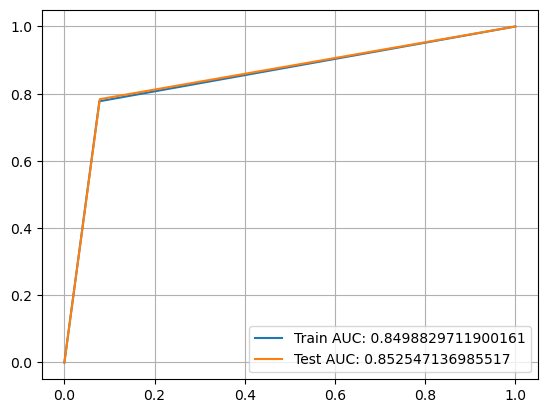

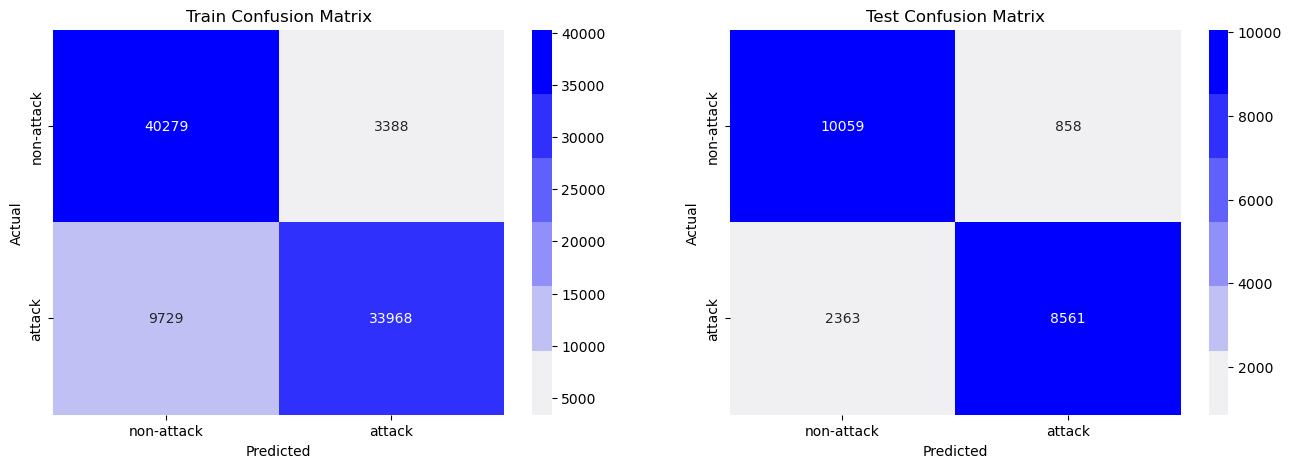

/tmp/ipykernel_7585/100658063.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [19]:
# Affichages des prédictions
model_name, test_auc, test_f1, test_far = evaluate_result(linear_svc, x_train, y_train, x_test, y_test, 'Linear svc')

# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)

In [20]:
# saving
pickle.dump(linear_svc, open(file_path+'linear_svc.pkl', 'wb'))

#### Linear SVC - Optimisé pour la vitesse - chat GPT - Vérification

In [21]:
speed_svc = LinearSVC(C=1.0, max_iter=10000)
speed_svc.fit(x_train, y_train)

LinearSVC(max_iter=10000)

In [22]:
#Performances

# testing 
y_pred = speed_svc.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision SVC - optimisé en vitesse : {accuracy:.5f}")

Précision SVC - optimisé en vitesse : 0.87949


+---------+--------------+--------------------+--------------------+---------------------+
| Dataset |    Model     |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+--------------+--------------------+--------------------+---------------------+
|  Train  | SVC Optimisé | 0.8776265827201817 | 0.8690498058953917 | 0.12237341727981835 |
|   Test  | SVC Optimisé | 0.8795126710389941 | 0.8715220150346578 | 0.12048732896100589 |
+---------+--------------+--------------------+--------------------+---------------------+


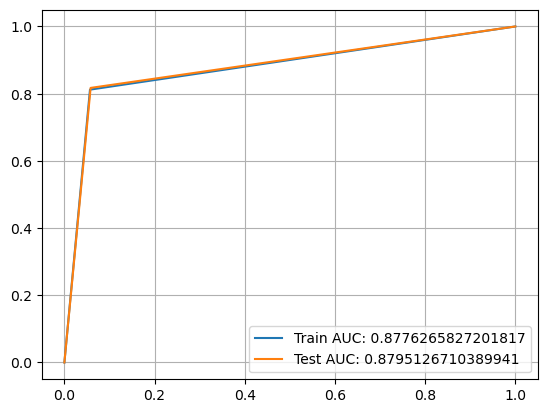

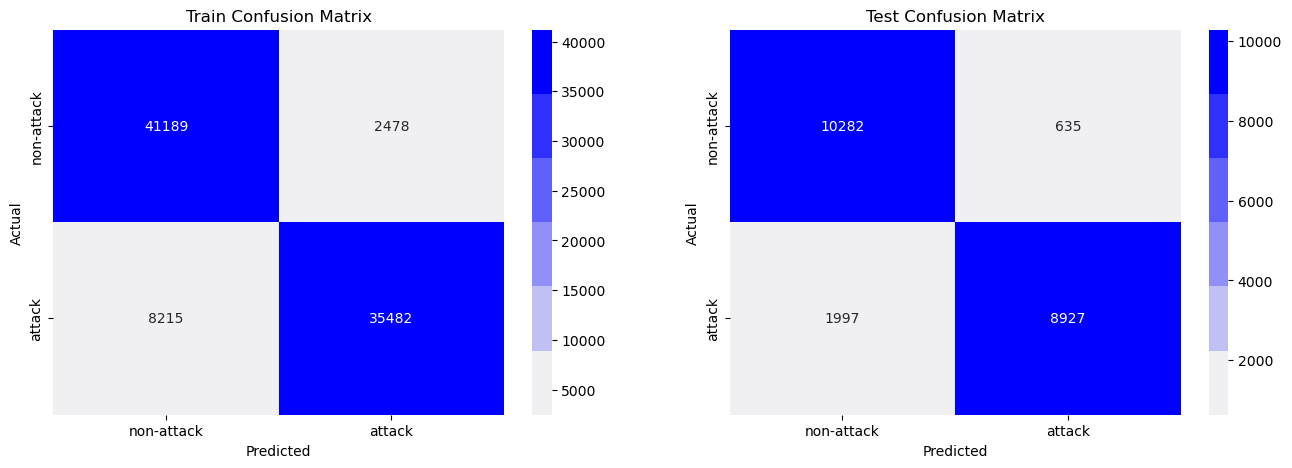

/tmp/ipykernel_7585/786230368.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [23]:
# Affichages des prédictions
model_name, test_auc, test_f1, test_far = evaluate_result(speed_svc, x_train, y_train, x_test, y_test, 'SVC Optimisé')


# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)

In [24]:
# saving
pickle.dump(speed_svc, open(file_path+'speed_svc.pkl', 'wb'))

#### SVC : Support Vector Classification (non linéraire) 

In [25]:

svc_ = SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, shrinking=True) # paramètres chat GPT
svc_.fit(x_train, y_train)

SVC()

In [26]:
#Performances

# testing 
y_pred = svc_.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision SVC : {accuracy:.5f}")

Précision SVC : 0.84497


+---------+-------+--------------------+--------------------+---------------------+
| Dataset | Model |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+-------+--------------------+--------------------+---------------------+
|  Train  |  SVC  | 0.8455118506342624 | 0.819686143572621  | 0.15448814936573757 |
|   Test  |  SVC  | 0.8450162945150498 | 0.8191625720999787 | 0.15498370548495025 |
+---------+-------+--------------------+--------------------+---------------------+


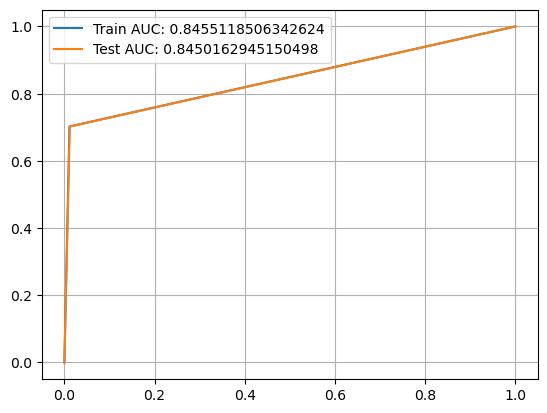

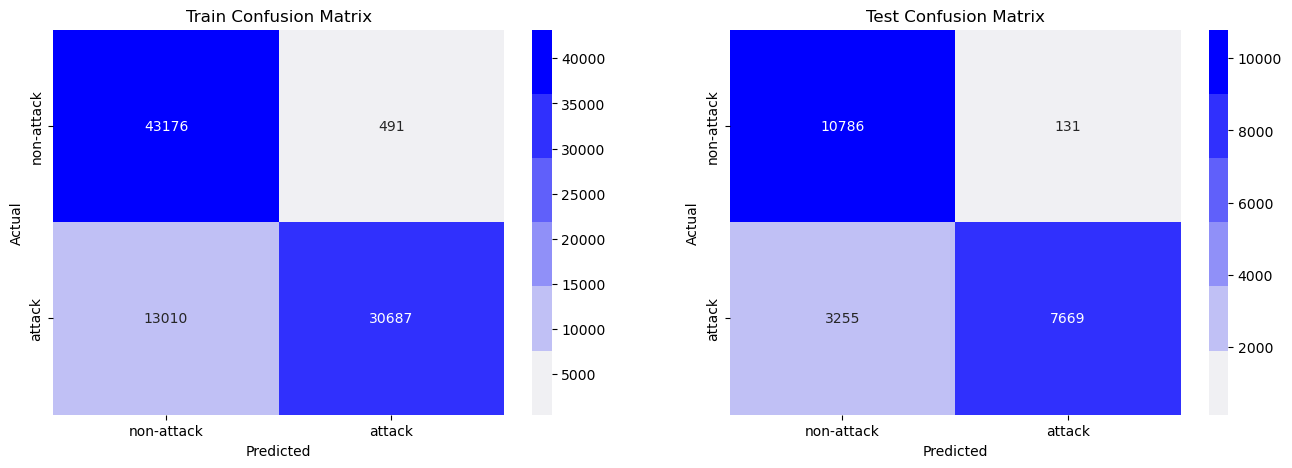

/tmp/ipykernel_7585/2708470536.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [27]:
# Affichages des prédictions
model_name, test_auc, test_f1, test_far = evaluate_result(svc_, x_train, y_train, x_test, y_test, 'SVC')

# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)

In [28]:
# saving
pickle.dump(speed_svc, open(file_path+'svc.pkl', 'wb'))

### 1.4 Training Random forest

Ici on va utiliser Gridsearch pour avoir des hyperparametres.\
Ainsi choisir les meilleurs réglages pour améliorer les performances du modèles


In [29]:

rf = RandomForestClassifier()

# paramètres vu avec l'autre note book de  IDS-UNSW-NB15
param = {
    'n_estimators': [10, 15, 20],
    'max_depth': [5, 10, 15]
}

# Best RandomForest model -> source UNSW-NB15: Machine Learning Models
#rf_bst_clf = RandomForestClassifier(criterion='gini', max_depth=5, min_samples_split=6, n_estimators=15, n_jobs=-1)
#rf_bst_clf.fit(x_train, y_train)
gds = GridSearchCV(estimator=rf, param_grid=param, cv=5, scoring='accuracy', n_jobs=-1)
gds.fit(x_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", gds.best_params_)

#prendre le meilleur modèle
best_rf = gds.best_estimator_

Meilleurs paramètres : {'max_depth': 15, 'n_estimators': 15}


In [30]:
#Performances

# testing 
y_pred = best_rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision Random Forest : {accuracy:.5f}")

Précision Random Forest : 0.99794


+---------+---------------+--------------------+--------------------+-----------------------+
| Dataset |     Model     |        AUC         |      F1-score      |    False Alarm Rate   |
+---------+---------------+--------------------+--------------------+-----------------------+
|  Train  | Random Forest | 0.9988554029361909 | 0.9988556257438432 | 0.0011445970638091392 |
|   Test  | Random Forest | 0.9979395224986967 | 0.9979411630141374 | 0.0020604775013033164 |
+---------+---------------+--------------------+--------------------+-----------------------+


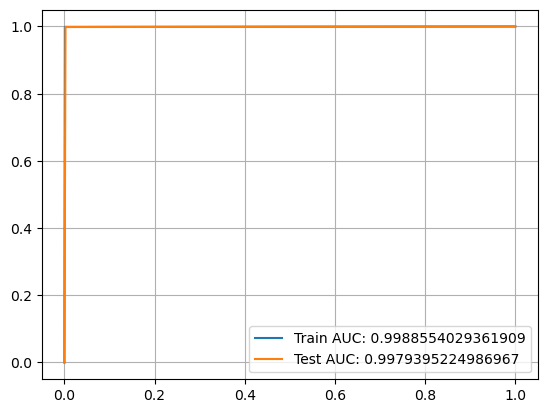

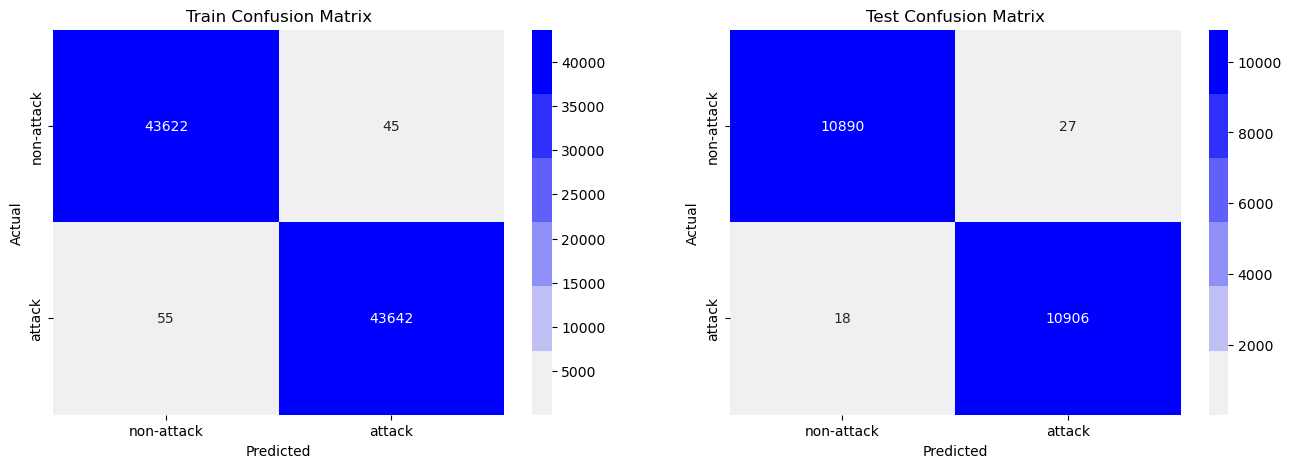

/tmp/ipykernel_7585/1234729037.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [31]:
# Affichages des prédictions
model_name, test_auc, test_f1, test_far = evaluate_result(best_rf, x_train, y_train, x_test, y_test, 'Random Forest')

# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)

In [32]:
# saving
pickle.dump(best_rf, open(file_path+'random_forest.pkl', 'wb'))

### 1.5 Training Decision tree
On va aussi utiliser GridSearch pour avoir les hyperparamètres.

In [33]:
dt = DecisionTreeClassifier()

param = {'criterion': ['gini', 'entropy'],
         'max_depth':[8, 10, 12, 14],
         'min_samples_split':[2, 4, 6],
         'min_samples_leaf': [1, 2, 5]
}

gds = GridSearchCV(estimator=dt, param_grid=param, cv=5, scoring='accuracy', n_jobs=-1)
gds.fit(x_train, y_train)
# Meilleurs paramètres
print("Meilleurs paramètres :", gds.best_params_)

#prendre le meilleur modèle
best_dt = gds.best_estimator_

Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [34]:
#Performances

# testing 
y_pred = best_dt.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision Decision Tree : {accuracy:.5f}")

Précision Decision Tree : 0.98672


+---------+---------------+--------------------+--------------------+----------------------+
| Dataset |     Model     |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+---------------+--------------------+--------------------+----------------------+
|  Train  | Decision Tree | 0.9880947205006648 | 0.9881365212630042 | 0.011905279499335328 |
|   Test  | Decision Tree | 0.9867213085172105 | 0.9867640346873574 | 0.013278691482789467 |
+---------+---------------+--------------------+--------------------+----------------------+


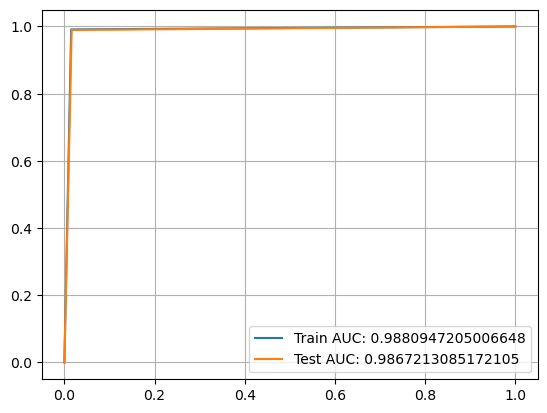

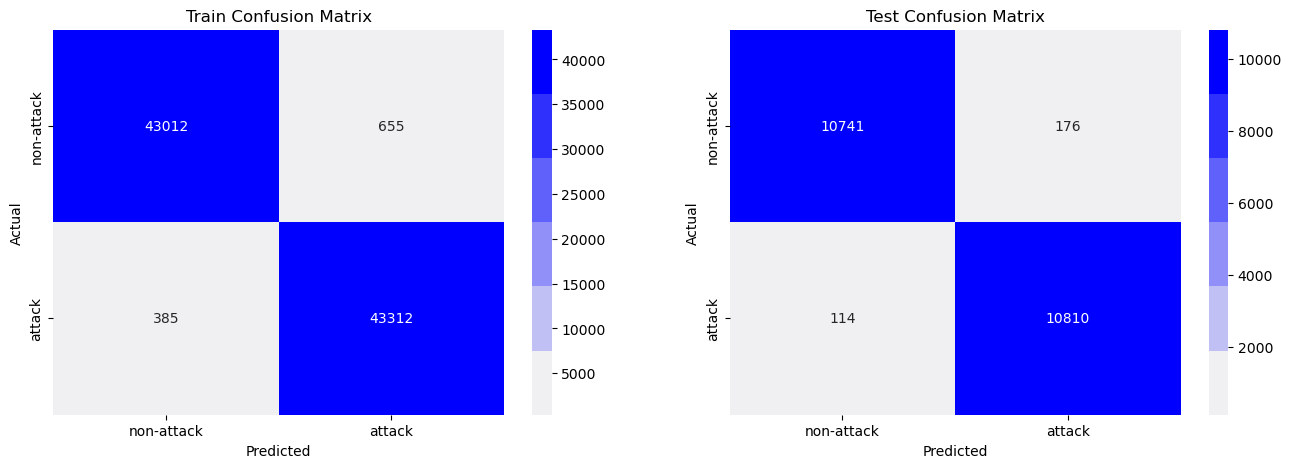

/tmp/ipykernel_7585/763948460.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [35]:
# Affichages des prédictions
model_name, test_auc, test_f1, test_far = evaluate_result(best_dt, x_train, y_train, x_test, y_test, 'Decision Tree')

# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)

In [36]:
# saving
pickle.dump(best_rf, open(file_path+'decision_tree.pkl', 'wb'))

## Neural Networks

### 1.6 Training MLP (Multi-Layer Perceptron)
Tutorial : https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html \
Normalement on doit transformer\


Le model suivi est celui dans l'example de finn. \
MLP à 3 couches dont 64 neurones par couches.\
epoch à 10, batch à 1000

In [37]:
class MLP(nn.Module): 
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, 64) #couche 1 , input_size = nb features
        self.l2 = nn.Linear(64,64)          #couche 2
        self.l3 = nn.Linear(64,1)           #couche 3
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.l1(x))  # Activation ReLU après la 1ère couche
        x = torch.relu(self.l2(x))  # Activation ReLU après la 2ème couche
        x = self.sigmoid(self.l3(x))  # Activation Sigmoid pour la sortie
        return x
        

In [38]:
# manipulation data
batch_size = 1000

# Standardisation des données
scaler = StandardScaler()
x_train_scal = scaler.fit_transform(x_train)
x_test_scal  = scaler.fit_transform(x_test)

# Convertir les données en tensor pytorch
x_train_tensor = torch.tensor(x_train_scal, dtype = torch.float32)
y_train_tensor  = torch.tensor(y_train, dtype = torch.float32)
x_test_tensor  = torch.tensor(x_test_scal, dtype = torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype = torch.float32)

# Créer les Dataloader pour les entrainnement et test
train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

test_data = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=True)


In [39]:
x_train.shape

(87364, 46)

In [40]:
# instanciation du model
nb_features = 46
mlp = MLP(nb_features)

In [41]:
# entrainnement
num_epochs = 10

# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()  # Perte binaire pour classification binaire
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

for epoch in range(num_epochs):
    mlp.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Passage avant
        outputs = mlp(inputs)
        
        # Calcul de la perte
        loss = criterion(outputs.squeeze(), labels.float())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
print("____ Training Succeesded")

____ Training Succeesded


In [42]:
# perf
mlp.eval()
with torch.no_grad():
    y_pred = mlp(x_test_tensor).squeeze()
    y_pred_class = (y_pred > 0.5).long()  # Si la probabilité > 0.5, prédire 1, sinon 0

    accuracy = (y_pred_class == y_test_tensor).float().mean()
    print(f"Précision MLP: {accuracy:.5f}")

Précision MLP: 0.97798


+---------+----------+--------------------+--------------------+----------------------+
| Dataset |  Model   |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+----------+--------------------+--------------------+----------------------+
|  Train  | MLP 3-64 | 0.9769387098227257 | 0.976731295541416  | 0.023061290177274405 |
|   Test  | MLP 3-64 | 0.9779802047854376 | 0.9777757242526453 | 0.02201979521456245  |
+---------+----------+--------------------+--------------------+----------------------+


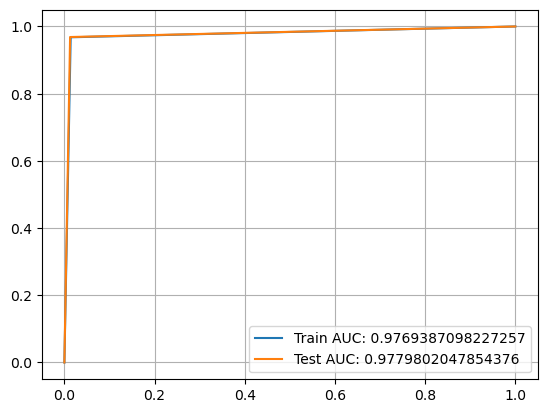

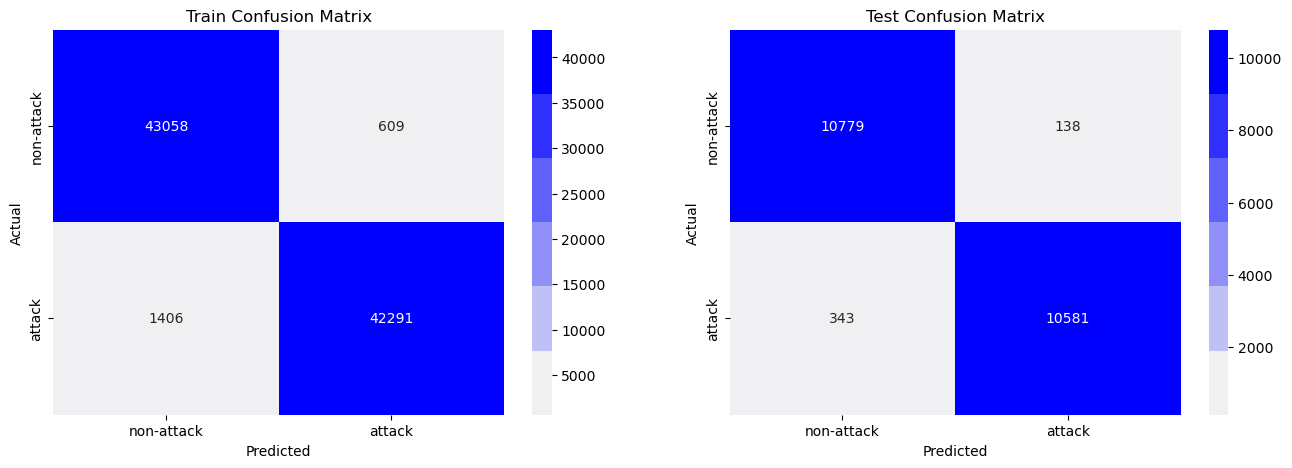

/tmp/ipykernel_7585/3581163160.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [43]:
model_name, test_auc, test_f1, test_far = evaluate_result_torch(mlp, x_train, y_train, x_test, y_test, model_name='MLP 3-64' , scaler=scaler)
# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [44]:
# sauver
torch.save(mlp.state_dict(), file_path+'mlp.pth')

### --- MLP with sklearn

In [45]:
# modif data
scaler = StandardScaler()
x_train_scal = scaler.fit_transform(x_train)
x_test_scal  = scaler.transform(x_test)

In [46]:

mlp_sk = MLPClassifier(
    hidden_layer_sizes=(64, 64, 64),  
    activation='relu',           # ReLU comme fonction d'activation
    solver='adam',               # Optimiseur Adam
    max_iter=500,                # Nombre maximal d'itérations
    random_state=42
)

mlp_sk.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 64, 64), max_iter=500, random_state=42)

In [47]:
#Performances

# testing 
y_pred = mlp_sk.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision MLP : {accuracy:.5f}")

# evaluation
score = mlp_sk.score(x_test, y_test)
print(f"Précision sur l'ensemble de test : {score:.5f}")

Précision MLP : 0.98265
Précision sur l'ensemble de test : 0.98265


+---------+------------------+--------------------+--------------------+----------------------+
| Dataset |      Model       |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+------------------+--------------------+--------------------+----------------------+
|  Train  | MLP with sklearn | 0.9846513499695179 | 0.9846143255429732 | 0.015348650030482226 |
|   Test  | MLP with sklearn | 0.9826484134624269 | 0.982593119919166  | 0.017351586537573026 |
+---------+------------------+--------------------+--------------------+----------------------+


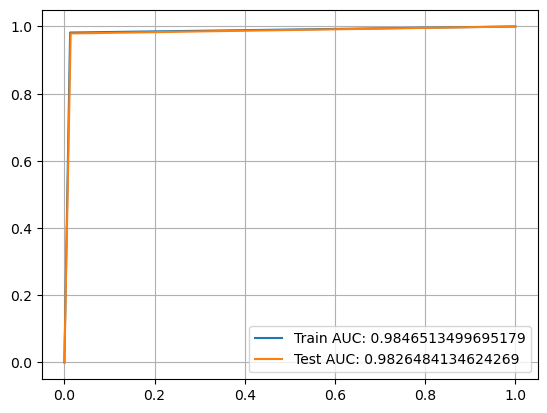

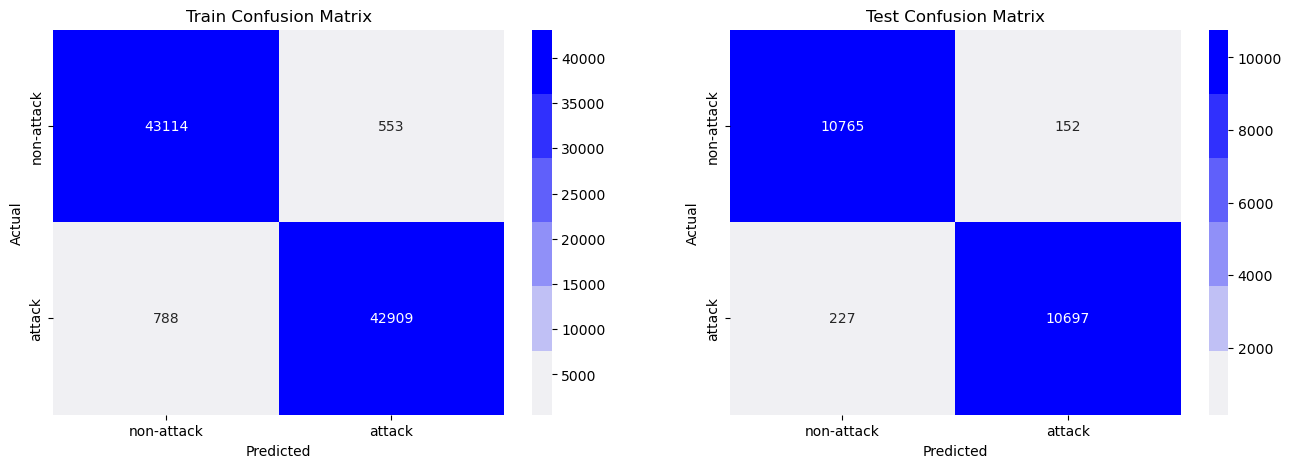

/tmp/ipykernel_7585/1471453411.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [48]:
# Affichages des prédictions
model_name, test_auc, test_f1, test_far = evaluate_result(mlp_sk, x_train, y_train, x_test, y_test, 'MLP with sklearn')

# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)

In [49]:
# saving
pickle.dump(mlp_sk, open(file_path+'mlp_sk.pkl', 'wb'))

 #### 1.7 Training Logistic Regression

In [50]:
lr_model = SGDClassifier(penalty='l1', alpha=1e-6)

In [51]:
lr_model.fit(x_train, y_train)

SGDClassifier(alpha=1e-06, penalty='l1')

In [52]:
#Performances

# testing 
y_pred = lr_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision Logistic Regression : {accuracy:.5f}")

Précision Logistic Regression : 0.81910


+---------+---------------------+--------------------+--------------------+---------------------+
| Dataset |        Model        |        AUC         |      F1-score      |   False Alarm Rate  |
+---------+---------------------+--------------------+--------------------+---------------------+
|  Train  | Logistic Regression | 0.8200799921221179 | 0.8391059965394736 | 0.17992000787788212 |
|   Test  | Logistic Regression | 0.8190632392943165 | 0.838517186414354  | 0.18093676070568354 |
+---------+---------------------+--------------------+--------------------+---------------------+


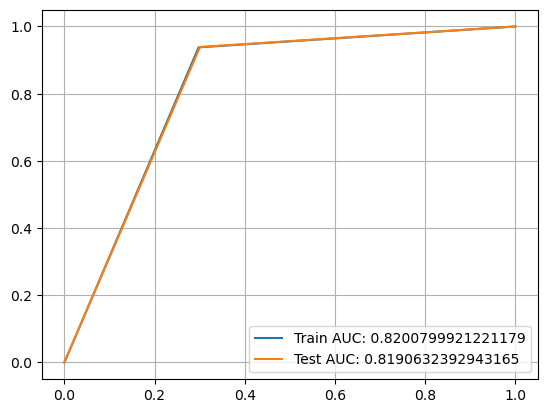

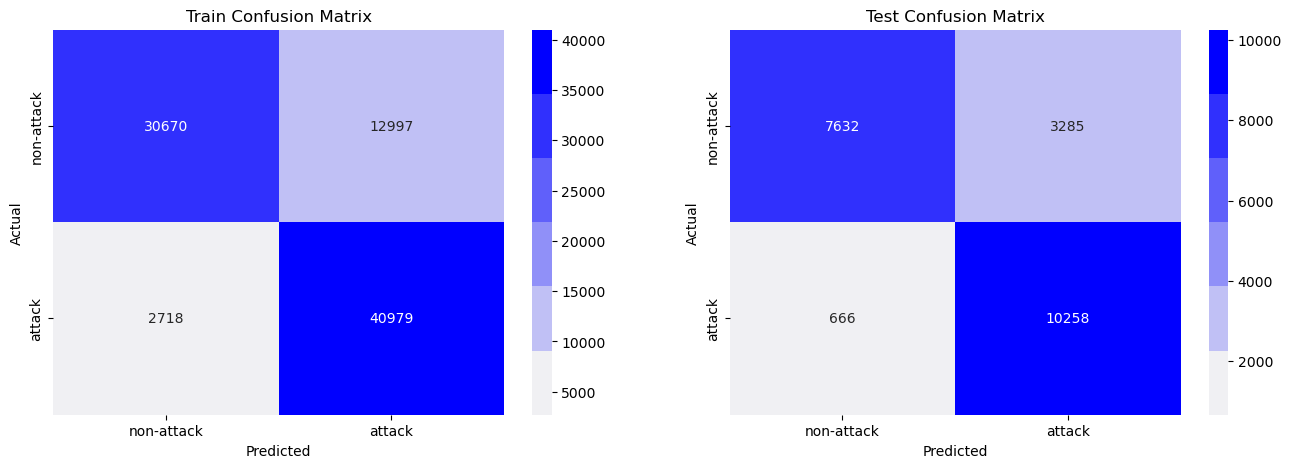

/tmp/ipykernel_7585/452744682.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [53]:
# Affichages des prédictions
model_name, test_auc, test_f1, test_far = evaluate_result(lr_model, x_train, y_train, x_test, y_test, 'Logistic Regression')

# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)

In [54]:
# saving
pickle.dump(best_rf, open(file_path+'logistic_regression.pkl', 'wb'))

#### 1.8 Training GBGT (Gradient boosted Decision tree)

In [55]:
# les paramètres ont été pris avec  IDS-UNSW-NB15
best_params = {'n_estimators':40,
               'max_depth':10,
               'learning_rate':0.1,
               'colsample_bylevel':0.5,
               'subsample':0.1,
               'n_jobs':-1}
xgb_clf = xgb.XGBClassifier(**best_params)

xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [56]:
#Performances

# testing 
y_pred = xgb_clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision Decision Tree : {accuracy:.5f}")

Précision Decision Tree : 0.99432


+---------+--------------------------------+--------------------+--------------------+----------------------+
| Dataset |             Model              |        AUC         |      F1-score      |   False Alarm Rate   |
+---------+--------------------------------+--------------------+--------------------+----------------------+
|  Train  | Gradient Boosted Decision tree | 0.9953181817609383 | 0.9953235230222162 | 0.004681818239061673 |
|   Test  | Gradient Boosted Decision tree | 0.9943223395584276 |  0.99432909539925  | 0.005677660441572268 |
+---------+--------------------------------+--------------------+--------------------+----------------------+


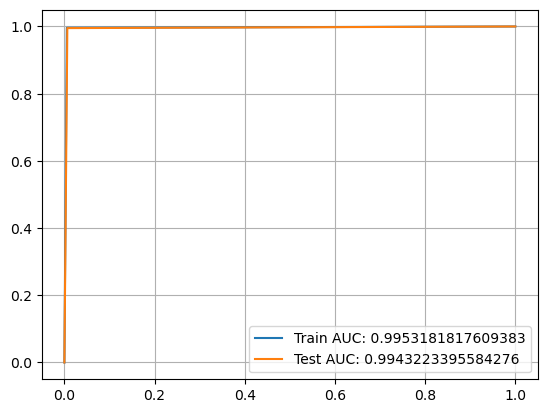

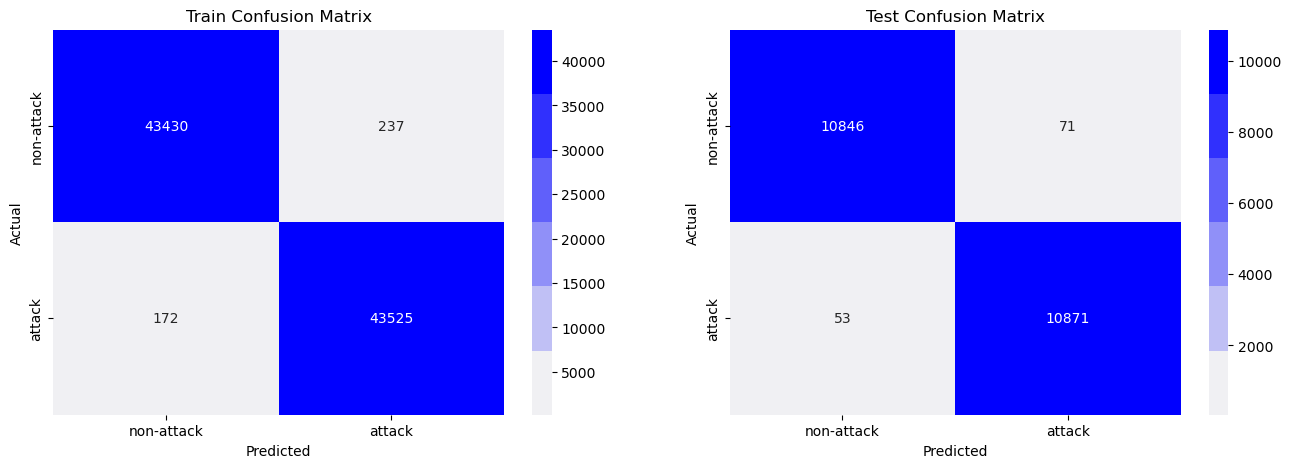

/tmp/ipykernel_7585/3492544901.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)


In [57]:
# Affichages des prédictions
model_name, test_auc, test_f1, test_far = evaluate_result(xgb_clf, x_train, y_train, x_test, y_test, 'Gradient Boosted Decision tree')

# Ajouter une nouvelle ligne au DataFrame avec les résultats retournés
compare = compare.append({'Model_Name': model_name, 'AUC': test_auc, 'F1': test_f1, 'FAR': test_far}, ignore_index=True)

In [58]:
# saving
pickle.dump(best_rf, open(file_path+'xgb.pkl', 'wb'))

## Non supervisé
### 1.9 Training clustering
Tutoriel : https://realpython.com/k-means-clustering-python/


In [59]:
# reading data + preparation
train_data_clust = pd.read_csv("train_data_clust.csv", sep=';', low_memory=False)
x_train_clust, y_train_clust = train_data_clust.drop(columns=['Normal/Attack']), train_data_clust['Normal/Attack']

test_data_clust = pd.read_csv("test_data_clust.csv",sep=';', low_memory=False)
x_test_clust, y_test_clust = test_data_clust.drop(columns=['Normal/Attack']), test_data_clust['Normal/Attack']


# Standardisation
x_train_clust_scal =scaler.fit_transform(x_train_clust)
x_test_clust_scal =scaler.fit_transform(x_test_clust)

In [60]:
# Creation du model
cluster = KMeans(
    init ="random", 
    n_clusters =2,
    n_init=10,
    max_iter=300,
    random_state=42
)

#entrainement
cluster.fit(x_train_clust_scal)

KMeans(init='random', n_clusters=2, n_init=10, random_state=42)

In [61]:
cluster.labels_[:] # à revoir

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [65]:
# Prédictions des clusters sur les données de test
y_test_pred = cluster.predict(x_test_clust_scal)

# Mapper les clusters aux labels réels
mapping = {}
for cluster_label in np.unique(y_test_pred):  # Parcourir les clusters prédits
    # Sélectionner les vrais labels correspondant aux points du cluster
    true_labels = y_test_clust[y_test_pred == cluster_label]  # Indexation booléenne NumPy
    
    if len(true_labels) > 0:
        # Assigner le label majoritaire du cluster
        cluster_mode = mode(true_labels, nan_policy='omit')
        # Si mode est un scalaire, il n'est pas nécessaire d'indexer
        mapping[cluster_label] = cluster_mode.mode
    else:
        mapping[cluster_label] = None

# Vérifier si le mapping est valide
if None in mapping.values():
    raise ValueError("Certains clusters n'ont pas pu être associés à des labels réels.")

# Appliquer le mapping aux prédictions
y_test_pred_mapped = [mapping[cluster] for cluster in y_test_pred]

# Calculer l'accuracy
accuracy = accuracy_score(y_test_clust, y_test_pred_mapped)

print(f"Accuracy: {accuracy:.5f}")


Accuracy: 0.97477


In [66]:
# saving
pickle.dump(cluster, open(file_path+'cluster.pkl', 'wb'))

## Comparaison des résultats

In [67]:
compare

,Model_Name,AUC,F1,FAR
0,Linear svc,0.852547,0.841665,0.147453
1,SVC Optimisé,0.879513,0.871522,0.120487
2,SVC,0.845016,0.819163,0.154984
3,Random Forest,0.997940,0.997941,0.002060
4,Decision Tree,0.986721,0.986764,0.013279
5,MLP 3-64,0.977980,0.977776,0.022020
6,MLP with sklearn,0.982648,0.982593,0.017352
7,Logistic Regression,0.819063,0.838517,0.180937
8,Gradient Boosted Decision tree,0.994322,0.994329,0.005678
